In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
total_sales_train = pd.read_parquet('../../data/processed/forecasting_df_train.to_parquet')
total_sales_test = pd.read_parquet('../../data/processed/forecasting_df_test.to_parquet')

In [27]:
total_sales_train.set_index('date', inplace=True)
total_sales_test.set_index('date', inplace=True)

In [28]:
import matplotlib.pyplot as plt

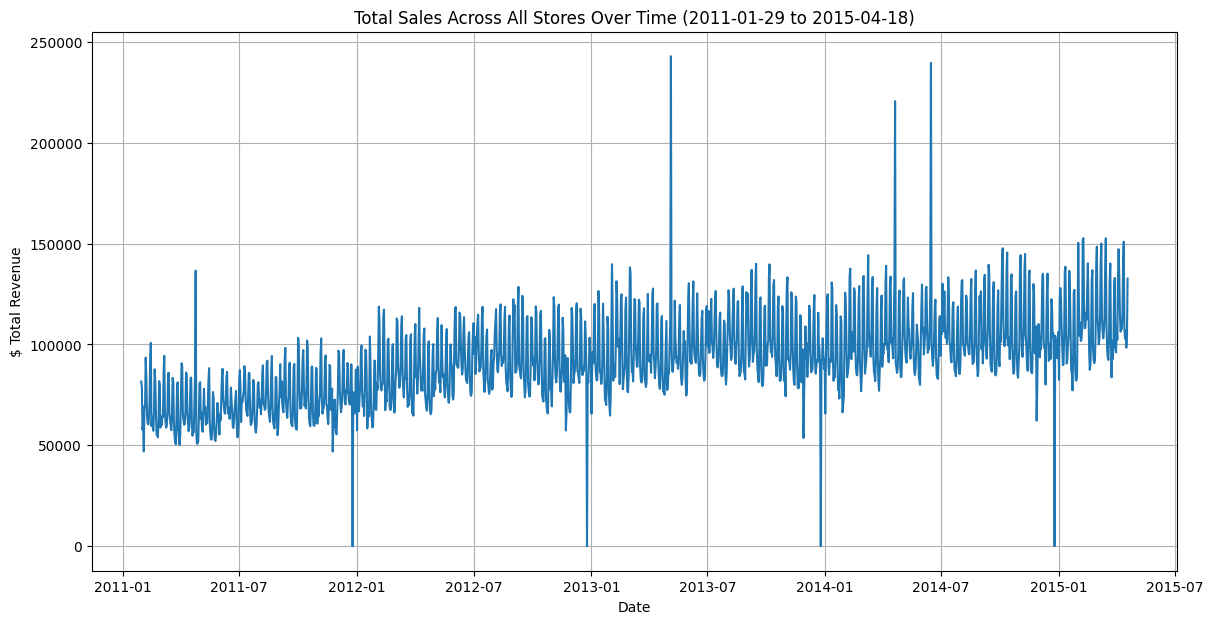

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(total_sales_train['total_revenue'])
plt.title('Total Sales Across All Stores Over Time (2011-01-29 to 2015-04-18)')
plt.ylabel('$ Total Revenue')
plt.xlabel('Date')
plt.grid(True)
plt.show()

#### Check Stationarity

In [30]:
import sys
sys.path.insert(0, '../../src')

In [31]:
from features.data_prep import adf_test

In [32]:
adf_test(total_sales_train['total_revenue'])

ADF Statistic: -1.868247678553163
p-value: 0.34714261537650515
Critical Values:
   1%, -3.434670849024842
Critical Values:
   5%, -2.863448384101514
Critical Values:
   10%, -2.5677859979567117
Data is non-stationary


The data is non-stationary, therefore, we need to difference the data

#### Differencing

In [33]:
total_sales_train_diff = total_sales_train.diff().dropna()

In [34]:
adf_test(total_sales_train_diff['total_revenue'])

ADF Statistic: -14.763786320041786
p-value: 2.3798722523543058e-27
Critical Values:
   1%, -3.4346737059247014
Critical Values:
   5%, -2.8634496449929934
Critical Values:
   10%, -2.567786669389711
Data is stationary


#### Seasonal Decompose

In [35]:
from features.data_prep import plot_decomposed_time_series

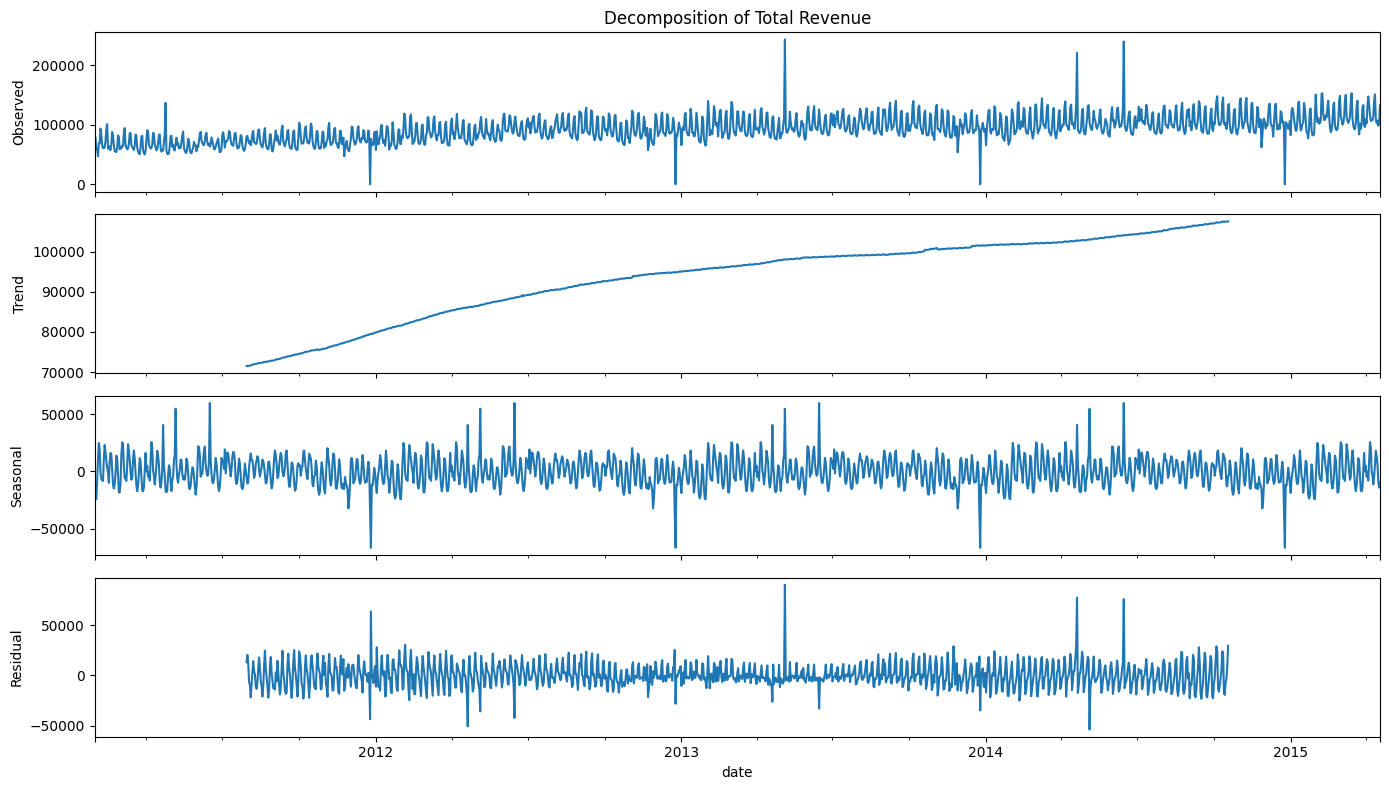

In [36]:
plot_decomposed_time_series(total_sales_train['total_revenue'], period=365)

### From the plot:
1. `Observed`: The total revenue over time.
2. `Trend`: There is a strong upward trend and suggest overall business growth.
3. `Seasonal`: It shows recurring patterns that repeat at regular intervals (365 days).
4. `Residual`: The remainder after remoivng the trend and seasonal components. It's represent the noise in the data.

#### Plot acf, pacf 

In [37]:
from features.data_prep import plot_acf_pacf

##### Lags = 7

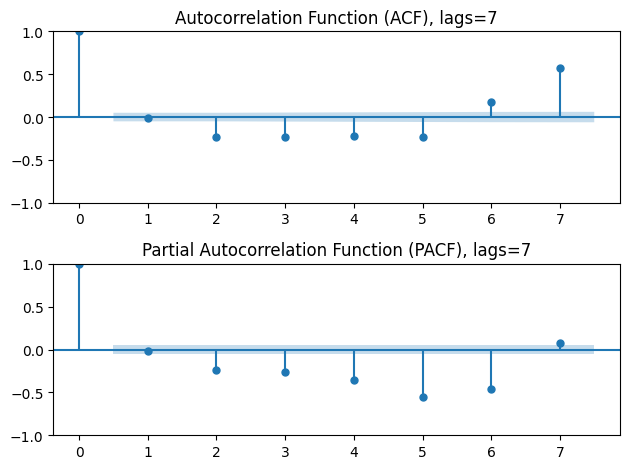

In [38]:
plot_acf_pacf(total_sales_train_diff['total_revenue'], lags=7)

##### Lags = 14

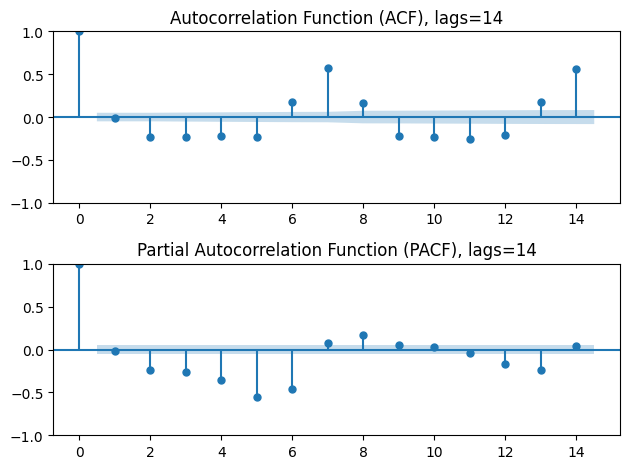

In [39]:
plot_acf_pacf(total_sales_train_diff['total_revenue'], lags=14)

##### Lags = 30

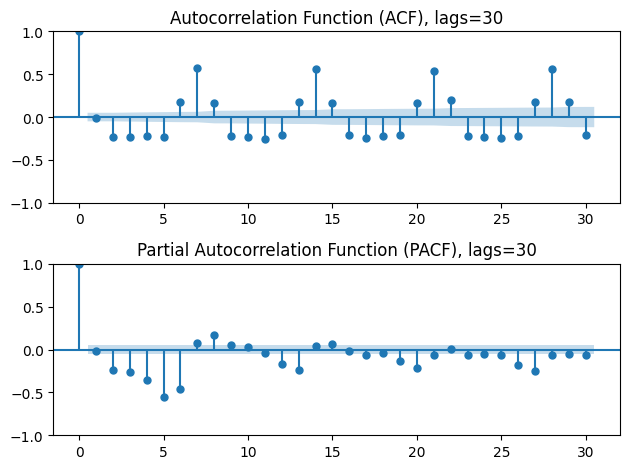

In [40]:
plot_acf_pacf(total_sales_train_diff['total_revenue'], lags=30)

Based on teh `ACF` and `PACF` after first order differencing:
- `ACF`: There is a significant spikes at lag7, which suggest a weekly sesonality. In addition, there is a recurring pattern of spikes at lag 14, 21, and so on, indicating a potential monthly seasonlity.

- `PACF`: The pattern of spikes are similar to ACF.

The `SARIMA` model (Seasonal Auto Regressive Integrated Moving Average) has parameters that control its AR(Auto Regressive), I (Integrated), and MA (Moving Avearage) parts.

1. `order`: (p, d, q):
- `p`: The order of the AR term. In the ACF plot, we will start with `p=6`
- `d`: The order of differencing, since we have differenced data once, `d=1`
- `q`: The oder of MA term. The ACF plot shows a sharp drop after a certain lag, `q=6`

2. `sesaonal_order`: (P, D, Q, s):
- `P`: The order of sesaonal AR. It's similar to `p`
- `D`: The order of seasonal Differencing. 
- `Q`: The order of the seasonal Moving Average term. Similar to `q`.
- `s`: The number of time steps for a single seasonal period. For daily data with weekly seasonality, we will use `s=7`

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
sarima_model = SARIMAX(
    total_sales_train,
    order=(6, 1, 6),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=True,
    enforce_invertibility=True,
)

/Users/narongvatchingpayakmon/Projects/Spring2023/adv_mla_2023/adv_mla_at2_14229898/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [43]:
sarima_fit = sarima_model.fit(disp=False)

/Users/narongvatchingpayakmon/Projects/Spring2023/adv_mla_2023/adv_mla_at2_14229898/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
forecast = sarima_fit.get_forecast(steps=7)

In [45]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [46]:
forecast_7_days = total_sales_test.iloc[:7]

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
predicted_total_sales = pd.DataFrame({'y_test': forecast_7_days['total_revenue'], 'y_pred': forecast_mean})
predicted_total_sales

,y_test,y_pred
2015-04-19,141758.65,138763.561970
2015-04-20,105781.23,105953.653140
2015-04-21,96606.05,98334.934452
2015-04-22,95237.65,97298.072463
2015-04-23,96460.08,95608.628160
2015-04-24,107246.87,106592.028571
2015-04-25,136837.46,133758.364508


In [49]:
rmse = mean_squared_error(forecast_7_days['total_revenue'], forecast_mean, squared=False)
print(f'RMSE for SARIMA model: {rmse}')

RMSE for SARIMA model: 1959.2010328174708


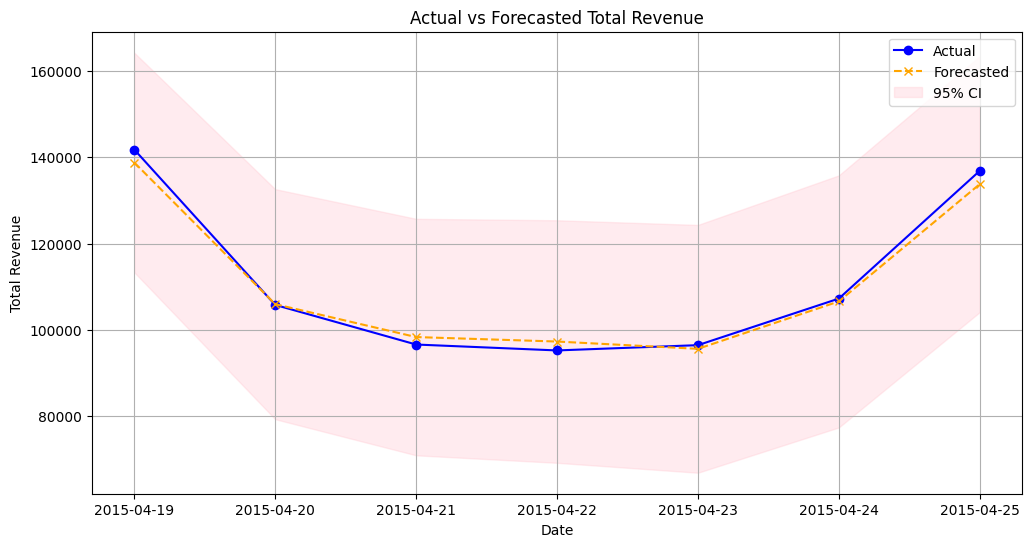

In [50]:
import matplotlib.pyplot as plt

dates = forecast_7_days.index

actual = forecast_7_days['total_revenue']
forecasted = forecast_mean.values

plt.figure(figsize=(12, 6))
plt.plot(dates, actual, color='blue', marker='o', label='Actual')
plt.plot(dates, forecasted, color='orange', marker='x', linestyle='--', label='Forecasted')
plt.fill_between(dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')

plt.title('Actual vs Forecasted Total Revenue')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.grid(True)
plt.show()